In [295]:
import math
from numpy import cos
import numpy as np
import matplotlib.pyplot as plt
import random,sys,os
import scipy.stats as st
import pandas as pd
pi=math.pi

### Problem 1

In [2]:
# use LHS to create x1,x2 with bounds 
import numpy as np
import matplotlib.pyplot as plt
from smt.sampling_methods import LHS

xlimits = np.array([[-5.0, 10.0], [0.0, 15.0]])
sampling = LHS(xlimits=xlimits)

In [3]:
#decide which sampling number to use based on the standard deviation of the y values
number=[10,50,500,1000,10000] # compare the standard deviation of the y values by varying the sampling number
y_std=[]
for i in number:
    x = sampling(i)
    x1=x[:,0]
    x2=x[:,1]
    y=10+10*(1-1/8*pi)*cos(x1)+(x2-(5.1/16*pi*pi)*x2**2+(5/pi)*x1-6)**2
    y_stdv=np.std(y)
    y_std.append(y_stdv)
print(y_std)

[124462.32441415278, 127730.22029254214, 128639.2910266363, 128821.08405074262, 128633.65434794227]


(500, 2)
(500,)
(500,)


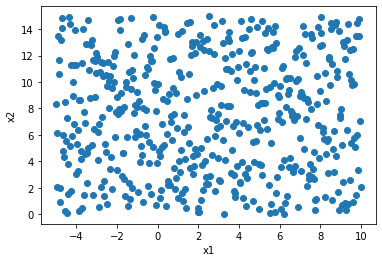

In [4]:
#since the standard deviations of are similar for 500,1000,and 10000, 
#use 500 as the sampling number to reduce calculation time
num = 500
x = sampling(num)
x1=x[:,0]
x2=x[:,1]

print(x.shape)
print(x1.shape)
print(x2.shape)

plt.plot(x1, x2, "o")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

In [5]:
#get y values from x1,x2

def bbf(x1,x2):
    return 10+10*(1-1/8*pi)*cos(x1)+(x2-(5.1/16*pi*pi)*x2**2+(5/pi)*x1-6)**2
y=bbf(x1,x2)
print(x.shape,y.shape)

(500, 2) (500,)


In [13]:
# collect data will be used for fitting and validating
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
print(x_train.shape,x_test.shape)
print(y_train.shape,y_test.shape)
N_train=y_train.size
print(N_train)

(335, 2) (165, 2)
(335,) (165,)
335


Latin Hyperbube Sampling(LHS) was used for sampling since it is a sampling method generating a quasi-random sampling distribution by optimizing the design using the Enhanced Stochastic Evolutionary algorithm (ESE). Standard deviation of the y values is used as the criteria to pick the number of points to collect. 

### Problem 2

1st Generalized linear regression with lasso and cross validation 

In [132]:
#prep data for P2
# scale the date from Problem 1
mins=np.min(x,axis=0)
maxs=np.max(x,axis=0)
y_mins=np.min(y)
y_maxs=np.max(y)

x_s=(x-mins[:])/(maxs[:]-mins[:])
y_s=(y-y_mins)/(y_maxs-y_mins)

#train test split for scaled data 
x_train, x_test, y_train, y_test = train_test_split(x_s, y_s, test_size=0.33, random_state=42)

In [227]:
from sklearn.model_selection import KFold
def GLR_1(x,y):

    kf=KFold(n_splits=5,random_state=1,shuffle=True)
    
    coffs=[]
    train_errs=[]
    
    i=0
    for train_index,test_index in kf.split(x,y):
        i+=1
        x_train,x_test=x[train_index],x[test_index]
        y_train,y_test=y[train_index],y[test_index]
        
        m = ConcreteModel()
        
        m.s=list(range(len(x_train)))
        m.yact=y_train
        m.x=x_train
     
        
        m.ypred=Var(m.s,within=NonNegativeReals)
        
        m.a = Var()
        m.b = Var()
        m.c = Var()
        m.d = Var()
        m.e = Var()
        m.f = Var()
        m.g = Var()

        
        def con_rule(m,i):
            return (m.a+m.b*m.x[:,0][i]+m.c*m.x[:,1][i]+m.d*(m.x[:,0][i]**2)+m.e*(m.x[:,1][i]**4)
                    +m.f*cos(m.x[:,0][i])+m.g*(m.x[:,0][i]*m.x[:,1][i]))-m.ypred[i]==0
        
        m.con = Constraint(m.s, rule=con_rule)
                    
        def obj_rule(m):
            alpha=0.1
            return((sum((m.ypred[i]-m.yact[i])**2 for i in m.s)/len(m.s))+alpha*(m.a+m.b+m.c+m.d+m.e+m.f+m.g))
       
        m.obj=Objective(rule=obj_rule)
        
        solver=SolverFactory('ipopt')
        solver.solve(m)
                    
        # err
        err_train=value(sum((m.yact[i]-m.ypred[i])**2 for i in m.s))
        train_errs.append(err_train)
        
      #  coffs=[]
      #  for i in range(8):
      #      coff=(value(m.a),value(m.b),value(m.c),value(m.d),value(m.e),value(m.f),value(m.g),value(m.h))
      #      coffs.append(coff)
        
        def surr(x):
            return(m.a+m.b*x[:,0]+m.c*x[:,1]+m.d*x[:,0]**2+m.e*x[:,1]**2+m.f*x[:,0]**4+m.g*cos(x[:,0])+m.h*(x[:,0]*x[:,1]))

        surr_error=(sum(m.yact[i]-surr(m.x)**2) for i in m.s)
        print(train_errs,surr_error)
                          
    return train_errs,surr_error

In [228]:
p2a1_1=GLR_1(x_s,y_s)

[26296.872125630878] <generator object GLR_1.<locals>.<genexpr> at 0x00000269F26413C0>
[26296.872125630878, 25392.54157406207] <generator object GLR_1.<locals>.<genexpr> at 0x00000269F50B2C10>
[26296.872125630878, 25392.54157406207, 27540.366193450725] <generator object GLR_1.<locals>.<genexpr> at 0x00000269F292CCF0>
[26296.872125630878, 25392.54157406207, 27540.366193450725, 25826.496540475033] <generator object GLR_1.<locals>.<genexpr> at 0x00000269F292CB30>
[26296.872125630878, 25392.54157406207, 27540.366193450725, 25826.496540475033, 26102.198416039108] <generator object GLR_1.<locals>.<genexpr> at 0x00000269F292CCF0>


2nd Genarlized 1st Generalized linear regression with lasso and cross validation

In [242]:
from sklearn.model_selection import KFold
def GLR_2(x,y):

    kf=KFold(n_splits=5,random_state=1,shuffle=True)
    
    coffs=[]
    train_errs=[]
    
    i=0
    for train_index,test_index in kf.split(x,y):
        i+=1
        x_train,x_test=x[train_index],x[test_index]
        y_train,y_test=y[train_index],y[test_index]
        
        m = ConcreteModel()
        
        m.s=list(range(len(x_train)))
        m.yact=y_train
        m.x=x_train
     
        
        m.ypred=Var(m.s,within=NonNegativeReals)
        
        m.a = Var()
        m.b = Var()
        m.c = Var()
        m.d = Var()
        m.e = Var()
        m.f = Var()
        m.g = Var()
        m.h = Var()
        m.k = Var()
        
        def con_rule(m,i):
            return (m.a+m.b*m.x[:,0][i]+m.c*m.x[:,1][i]+m.d*(m.x[:,0][i]**2)+m.e*(m.x[:,1][i]**2)
                    +m.f*(m.x[:,0][i]**3)+m.g*(m.x[:,0][i]*m.x[:,1][i])+m.h*((m.x[:,0][i]**2)*m.x[:,1][i])
                    +m.k*(m.x[:,0][i]*(m.x[:,1][i]**2)))-m.ypred[i]==0
        
        m.con = Constraint(m.s, rule=con_rule)
                    
        def obj_rule(m):
            alpha=0.1
            return(sum((m.ypred[i]-m.yact[i])**2 for i in m.s)/len(m.s))
       
        m.obj=Objective(rule=obj_rule)
        
        solver=SolverFactory('ipopt')
        solver.solve(m)
                    
        # err
        err_train=value(sum((m.yact[i]-m.ypred[i])**2 for i in m.s))
        train_errs.append(err_train)
        
      #  coffs=[]
      #  for i in range(8):
      #      coff=(value(m.a),value(m.b),value(m.c),value(m.d),value(m.e),value(m.f),value(m.g),value(m.h))
      #      coffs.append(coff)
        
        def surr(x):
            return(m.a+m.b*x[:,0]+m.c*x[:,1]+m.d*x[:,0]**2+m.e*x[:,1]**2+m.f*x[:,0]**4+m.g*cos(x[:,0])+m.h*(x[:,0]*x[:,1]))

        surr_error=(sum(m.yact[i]-surr(m.x)**2) for i in m.s)
        print(train_errs,surr_error)
                          
    return train_errs,surr_error

In [243]:
p2a1_2=GLR_2(x_s,y_s)

[0.8821593428298521] <generator object GLR_2.<locals>.<genexpr> at 0x00000269F40835F0>
[0.8821593428298521, 0.9016447796162695] <generator object GLR_2.<locals>.<genexpr> at 0x00000269F50C14A0>
[0.8821593428298521, 0.9016447796162695, 0.8665905694426078] <generator object GLR_2.<locals>.<genexpr> at 0x00000269F40835F0>
[0.8821593428298521, 0.9016447796162695, 0.8665905694426078, 0.9181486231080812] <generator object GLR_2.<locals>.<genexpr> at 0x00000269F50C14A0>
[0.8821593428298521, 0.9016447796162695, 0.8665905694426078, 0.9181486231080812, 0.8432959849605555] <generator object GLR_2.<locals>.<genexpr> at 0x00000269F24E4C10>


We can see that both the training error and surrogate model error are smaller when we use the 2nd generalized linear regression fuction. We will use 2nd GLR for the following part. 

### Problem2 (b）refit the 2nd GLP to get the optimial parameters 

In [260]:
m = ConcreteModel()
        
m.s=list(range(len(x_train)))
m.yact=y_train
m.x=x_train


m.ypred=Var(m.s,within=NonNegativeReals)

m.a = Var()
m.b = Var()
m.c = Var()
m.d = Var()
m.e = Var()
m.f = Var()
m.g = Var()
m.h = Var()
m.k = Var()

def con_rule(m,i):
    return (m.a+m.b*m.x[:,0][i]+m.c*m.x[:,1][i]+m.d*(m.x[:,0][i]**2)+m.e*(m.x[:,1][i]**2)
            +m.f*(m.x[:,0][i]**3)+m.g*(m.x[:,0][i]*m.x[:,1][i])+m.h*((m.x[:,0][i]**2)*m.x[:,1][i])
            +m.k*(m.x[:,0][i]*(m.x[:,1][i]**2)))-m.ypred[i]==0

def obj_rule(model): 
    return sum((model.ypred[i]-model.yact[i])**2 for i in model.s)

m.con = Constraint(m.s, rule=con_rule)

m.obj=Objective(rule=obj_rule)

solver=SolverFactory('ipopt')
solver.solve(m)

m.a.pprint()
m.b.pprint()
m.c.pprint()
m.e.pprint()
m.f.pprint()
m.g.pprint()
m.h.pprint()
m.k.pprint()
m.obj.pprint()

a : Size=1, Index=None
    Key  : Lower : Value               : Upper : Fixed : Stale : Domain
    None :  None : 0.10558777841376633 :  None : False : False :  Reals
b : Size=1, Index=None
    Key  : Lower : Value               : Upper : Fixed : Stale : Domain
    None :  None : 0.04104577482476994 :  None : False : False :  Reals
c : Size=1, Index=None
    Key  : Lower : Value               : Upper : Fixed : Stale : Domain
    None :  None : -0.8309440317966522 :  None : False : False :  Reals
e : Size=1, Index=None
    Key  : Lower : Value              : Upper : Fixed : Stale : Domain
    None :  None : 1.6354480344628344 :  None : False : False :  Reals
f : Size=1, Index=None
    Key  : Lower : Value                 : Upper : Fixed : Stale : Domain
    None :  None : -0.012122953263856687 :  None : False : False :  Reals
g : Size=1, Index=None
    Key  : Lower : Value                : Upper : Fixed : Stale : Domain
    None :  None : -0.14413733510942384 :  None : False : False :  

### problem 2(c)

In [353]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

alphas = np.array([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])

listEstimator = []
listScore = []
for alpha in alphas:
    
    x_train, x_test, y_train, y_test = train_test_split(x_s, y_s, test_size = 0.3)
     
    lasso = Lasso()
    param_grid = {'alpha': alphas}
    lasso_search = GridSearchCV(lasso, param_grid, cv = 5)
    lasso_search.fit(x_train, y_train)
    
    listEstimator.append(lasso_search.best_estimator_)
    
    score = lasso_search.best_estimator_.score(x_test, y_test)
    listScore.append(score)
    
maxIndex = listScore.index(max(listScore))
optAlpha = listEstimator[maxIndex].alpha


print('Optimal alpha: {}'.format(optAlpha))


Optimal alpha: 0.001


In [356]:
m = ConcreteModel()

m.s=list(range(len(x_train)))
m.yact=y_train
m.x=x_train


m.ypred=Var(m.s,within=NonNegativeReals)

m.a = Var()
m.b = Var()
m.c = Var()
m.d = Var()
m.e = Var()
m.f = Var()
m.g = Var()
m.h = Var()
m.k = Var()

def con_rule(m,i):
    return (m.a+m.b*m.x[:,0][i]+m.c*m.x[:,1][i]+m.d*(m.x[:,0][i]**2)+m.e*(m.x[:,1][i]**2)
            +m.f*(m.x[:,0][i]**3)+m.g*(m.x[:,0][i]*m.x[:,1][i])+m.h*((m.x[:,0][i]**2)*m.x[:,1][i])
            +m.k*(m.x[:,0][i]*(m.x[:,1][i]**2)))-m.ypred[i]==0

m.con = Constraint(m.s, rule=con_rule)

def obj_rule(m):
    alpha=0.001
    return(sum((m.ypred[i]-m.yact[i])**2 for i in m.s)/len(m.s))

m.obj=Objective(rule=obj_rule)

solver=SolverFactory('ipopt')
solver.solve(m)

m.a.pprint()
m.b.pprint()
m.c.pprint()
m.e.pprint()
m.f.pprint()
m.g.pprint()
m.h.pprint()
m.k.pprint()
m.obj.pprint()
                          
   

a : Size=1, Index=None
    Key  : Lower : Value              : Upper : Fixed : Stale : Domain
    None :  None : 0.1133046078330596 :  None : False : False :  Reals
b : Size=1, Index=None
    Key  : Lower : Value                  : Upper : Fixed : Stale : Domain
    None :  None : -0.0017836734246640378 :  None : False : False :  Reals
c : Size=1, Index=None
    Key  : Lower : Value               : Upper : Fixed : Stale : Domain
    None :  None : -0.8685253964124448 :  None : False : False :  Reals
e : Size=1, Index=None
    Key  : Lower : Value             : Upper : Fixed : Stale : Domain
    None :  None : 1.660932382264804 :  None : False : False :  Reals
f : Size=1, Index=None
    Key  : Lower : Value                 : Upper : Fixed : Stale : Domain
    None :  None : -0.005395841157457647 :  None : False : False :  Reals
g : Size=1, Index=None
    Key  : Lower : Value               : Upper : Fixed : Stale : Domain
    None :  None : 0.06461604858008668 :  None : False : False :  

### Problem 3

In [261]:
from sklearn.model_selection import KFold
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor
kf = KFold(n_splits = 5,shuffle=False)

r2_test = []

for train_index, test_index in kf.split(x):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
  
    model_GPR = GaussianProcessRegressor() #create a linear regression model instance
    model_GPR.fit(x_train, y_train) #fit the model
    r2 = model_GPR.score(x_train, y_train) #get the "score", which is equivalent to r^2
    print('r^2 training = {}'.format(r2))

    yhat_GPR = model_GPR.predict(x_test) #create the model prediction

    r2 = model_GPR.score(x_test, y_test) #get the "score", which is equivalent to r^2
    print('r^2 testing = {}'.format(r2))
    r2_test.append(r2)
    

r^2 training = 0.9999999999999999
r^2 testing = 0.998128625948059
r^2 training = 1.0
r^2 testing = 0.9978619724806295
r^2 training = 1.0
r^2 testing = 0.9989544766877512
r^2 training = 1.0
r^2 testing = 0.9952844316493028
r^2 training = 1.0
r^2 testing = 0.9992088740140322


(a)This is not a good fitting since r^2 for both training and testing are close to 1 meaning it is over fitting. 

In [266]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
kernel=RBF(0.1)
model=GaussianProcessRegressor(kernel=kernel,normalize_y=True)
model.fit(x_s,y_s)

GaussianProcessRegressor(kernel=RBF(length_scale=0.1), normalize_y=True)

In [312]:
from scipy.optimize import minimize
def fitGPM(x):
    return model.predict(np.atleast_2d(x))
GPM=fitGPM(x_s)

x0=x_s[1,:]
result=minimize(fitGPM,x0,method='Nelder-Mead')
print(result)

 final_simplex: (array([[0.96339861, 0.12319149],
       [0.96336793, 0.12320003],
       [0.96348869, 0.12321562]]), array([-1.27345163e-06, -1.27343910e-06, -1.27343525e-06]))
           fun: -1.2734516258439132e-06
       message: 'Optimization terminated successfully.'
          nfev: 84
           nit: 44
        status: 0
       success: True
             x: array([0.96339861, 0.12319149])


### (c) 



Problem 2c is better since Problem 3 c only minimizing of scalar function of one or more variables using the Nelder-Mead algorithm.

### Problem4

In [39]:
# find optimal w values
model=ConcreteModel()
model.d=[0,1]
model.c=10086
model.ep=0.001

model.s=np.arange(0,len(y))#Samples
model.xs=x
model.yact=y

model.zetaplus=Var(model.s,within=NonNegativeReals)
model.zetaminus=Var(model.s,within=NonNegativeReals)

model.b=Var()
model.w=Var(model.d)

def con(m,i):
    return model.yact[i]-(model.b+sum(model.w[j]+model.xs[i,j] for j in model.d))<= model.ep+model.zetaplus[i]
model.con=Constraint(model.s,rule=con)

def con1(m,i):
    return (model.b+sum(model.w[j]+model.xs[i,j] for j in model.d)) - model.yact[i]<=model.ep+model.zetaminus[i]
model.con1=Constraint(model.s,rule=con1)

def obj_rule(m):
    return 0.5*sum(model.w[i] for i in model.d)**2+model.c*sum(model.zetaplus[i]+model.zetaminus[i] for i in model.s)
model.obj=Objective(rule=obj_rule)

solver=SolverFactory('ipopt')
solver.solve(model)
model.b.pprint()
model.w.pprint()

b : Size=1, Index=None
    Key  : Lower : Value             : Upper : Fixed : Stale : Domain
    None :  None : 30031.75402756791 :  None : False : False :  Reals
w : Size=2, Index=w_index
    Key : Lower : Value              : Upper : Fixed : Stale : Domain
      0 :  None :  74.90817668589827 :  None : False : False :  Reals
      1 :  None : -74.90817668589827 :  None : False : False :  Reals


### Problem 5

#### (a)

In [330]:
df = pd.read_excel('data/ENB2012_data.xlsx')
print(df.shape)
df.head(10)

(768, 10)


,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Height,Orientation,Glazing_Area,Glazing_A_Distribution,Heating_Load,Cooling_Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28
5,0.90,563.5,318.5,122.50,7.0,3,0.0,0,21.46,25.38
6,0.90,563.5,318.5,122.50,7.0,4,0.0,0,20.71,25.16
7,0.90,563.5,318.5,122.50,7.0,5,0.0,0,19.68,29.60
8,0.86,588.0,294.0,147.00,7.0,2,0.0,0,19.50,27.30
9,0.86,588.0,294.0,147.00,7.0,3,0.0,0,19.95,21.97


In [347]:
# Features Separation
df_feature = df.iloc[:,1:10]

In [348]:
df_feature.head(10)

,Surface_Area,Wall_Area,Roof_Area,Height,Orientation,Glazing_Area,Glazing_A_Distribution,Heating_Load,Cooling_Load
0,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28
5,563.5,318.5,122.50,7.0,3,0.0,0,21.46,25.38
6,563.5,318.5,122.50,7.0,4,0.0,0,20.71,25.16
7,563.5,318.5,122.50,7.0,5,0.0,0,19.68,29.60
8,588.0,294.0,147.00,7.0,2,0.0,0,19.50,27.30
9,588.0,294.0,147.00,7.0,3,0.0,0,19.95,21.97


In [349]:
from sklearn.preprocessing import StandardScaler


# Data Processing
scaler = StandardScaler()
scaler.fit(df_feature)
feature_scaled = scaler.transform(df_feature)

from sklearn.decomposition import PCA

pca = PCA(n_components = 5)  # started with half of the feature
pc = pca.fit_transform(feature_scaled)

pc_df = pd.DataFrame(data = pc, columns = ['PC1', 'PC2', 'PC3', 'PC4','PC5'])

# Variance Calculation
var = pca.explained_variance_ratio_ 
pc_var_df = pd.DataFrame({'var' : var, 'PC': ['PC1', 'PC2', 'PC3', 'PC4','PC5']})
pc_var_df

,var,PC
0,0.503558,PC1
1,0.144997,PC2
2,0.130061,PC3
3,0.111131,PC4
4,0.089414,PC5


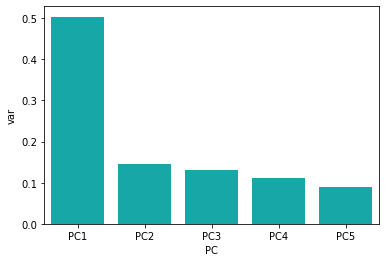

In [350]:
import seaborn as sns
sns.barplot(x = 'PC', y = 'var', data = pc_var_df, color = 'c');

PC1 is contributing to 50.3% of the data. The first three PCs contrinuts 85% of the data. 

##### (b)

Loadings: 
 [[-3.84923241e-01  1.65013956e-01 -4.55048232e-01  4.58765218e-01
   1.48672672e-03  6.19321421e-02  2.12548716e-02  4.48805287e-01
   4.48725216e-01]
 [-3.58722808e-01 -4.36335137e-01 -1.39073042e-01  1.29231985e-01
  -4.45233357e-03 -5.94595030e-01 -4.89921478e-01 -1.86341678e-01
  -1.28755699e-01]
 [ 3.54622229e-01  7.12179087e-01  1.85346566e-03  1.28347648e-03
   4.76349562e-03 -3.97273375e-01 -4.49464774e-01  5.25926439e-02
   6.63742937e-02]
 [ 1.12522245e-03  8.45737910e-03 -2.98730809e-03  2.71447287e-03
  -9.99868147e-01  2.13850419e-05  2.76637762e-03  6.43352367e-03
  -1.12053620e-02]
 [-8.90805988e-03  1.32039251e-01 -7.24559572e-02  6.47055307e-02
   3.78929072e-03 -6.36951682e-01  7.46322438e-01 -7.74610796e-02
  -6.58058349e-02]]


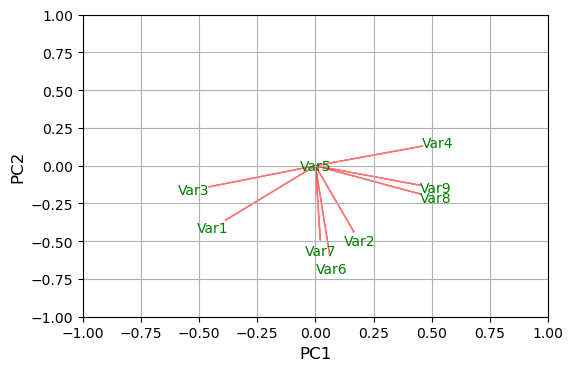

In [344]:
loadings = pca.components_
print('Loadings: \n', loadings)

def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    sclaex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    
    plt.figure(figsize=(6,4), dpi=100)
    for i in range(n):
        plt.arrow(0,0,coeff[i,0], coeff[i,1],color = 'r',alpha=0.5)
        if labels is None:
            plt.text(coeff[i,0]*1.15, coeff[i,1] * 1.15,'Var'+str(i+1),color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]*1.15, coeff[i,1] * 1.15, labels[i],color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel('PC{}'.format(1), size=12)
    plt.ylabel("PC{}".format(2), size=12)
    plt.grid()

myplot(pc[:,0:2], np.transpose(pca.components_[0:2,:]));

#### (c)

PCA is helpful in terms of identifying that PC1 is contributing to 50.3% of the data. The first three PCs contrinuts 85% of the data. Loadings plotting gives the information that how varibales are correlated with each other. 